### Cumulative Total Returns & Risk-Adjusted Returns
In the project I'm calculating cumulative total returns for stocks and then combine them into a portfolio. I also calculate risks on the security and portfolio level.

In [87]:
import pandas as pd
import numpy as np
import pyodbc 
from matplotlib import pyplot as plt

cnxn = pyodbc.connect("Driver={SQL Server};Server=qai97-qadirectcloud-default-0j.database.windows.net;UID=0j.ivan.stroshkov;PWD=DwT!dYcV4Eaq%6L9;Database=qai;")
sql = """
SELECT dbo.DS2Company.DsCmpyName, dbo.DS2PrimQtPrc.MarketDate, dbo.DS2PrimQtPrc.Close_, dbo.DS2Div.EffectiveDate, dbo.DS2Div.DivRate
FROM dbo.DS2Company
JOIN DBO.DS2Security
ON DBO.DS2Company.DsCmpyCode = DBO.DS2Security.DsCmpyCode
JOIN DBO.DS2ISINChg
ON DBO.DS2Security.DsSecCode = DBO.DS2ISINChg.DsSecCode
JOIN DS2CtryQtInfo
ON DBO.DS2ISINChg.DsSecCode = DS2CtryQtInfo.DsSecCode
JOIN dbo.DS2PrimQtPrc
ON DS2CtryQtInfo.InfoCode = dbo.DS2PrimQtPrc.InfoCode
LEFT JOIN dbo.DS2Div
ON dbo.DS2PrimQtPrc.InfoCode = dbo.DS2Div.InfoCode AND dbo.DS2PrimQtPrc.MarketDate = dbo.DS2Div.EffectiveDate
WHERE (DBO.DS2ISINChg.ISIN = 'RU000A0B90N8' OR DBO.DS2ISINChg.ISIN = 'RU000A0JP7J7')
AND  (dbo.DS2PrimQtPrc.MarketDate BETWEEN '2019-01-01 00:00:00.000' AND '2019-12-31 00:00:00.000')
ORDER BY dbo.DS2Company.DsCmpyName;
"""
df = pd.read_sql_query(sql, cnxn)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 5 columns):
DsCmpyName       504 non-null object
MarketDate       504 non-null datetime64[ns]
Close_           504 non-null float64
EffectiveDate    2 non-null datetime64[ns]
DivRate          2 non-null float64
dtypes: datetime64[ns](2), float64(2), object(1)
memory usage: 19.8+ KB


,DsCmpyName,MarketDate,Close_,EffectiveDate,DivRate
0,PIK GROUP,2019-07-31,395.00000,NaT,NaN
1,PIK GROUP,2019-10-25,336.00000,NaT,NaN
2,PIK GROUP,2019-06-24,370.39991,NaT,NaN
3,PIK GROUP,2019-03-13,353.80005,NaT,NaN
4,PIK GROUP,2019-07-17,383.89991,NaT,NaN


In [70]:
df.fillna(value={'DivRate':0}, inplace=True)
df['Total_sum'] = df['Close_'] + df['DivRate']
df.rename(columns={'DsCmpyName':'Company', 'Close_':'Close'}, inplace=True)
df.head()

,Company,MarketDate,Close,EffectiveDate,DivRate,Total_sum
0,PIK GROUP,2019-07-31,395.00000,NaT,0.0,395.00000
1,PIK GROUP,2019-10-25,336.00000,NaT,0.0,336.00000
2,PIK GROUP,2019-06-24,370.39991,NaT,0.0,370.39991
3,PIK GROUP,2019-03-13,353.80005,NaT,0.0,353.80005
4,PIK GROUP,2019-07-17,383.89991,NaT,0.0,383.89991


In [71]:
pivoted = df.pivot(index= 'MarketDate', columns = 'Company', values = ['Close', 'DivRate', 'Total_sum'])
pivoted

Close                         DivRate                        \
Company     PIK GROUP RASPADSKAYA COAL OJSC PIK GROUP RASPADSKAYA COAL OJSC   
MarketDate                                                                    
2019-01-03  374.69996             127.98000       0.0                   0.0   
2019-01-04  375.19996             127.70000       0.0                   0.0   
2019-01-08  376.60010             126.84000       0.0                   0.0   
2019-01-09  374.69996             128.72001       0.0                   0.0   
2019-01-10  374.19996             128.20000       0.0                   0.0   
...               ...                   ...       ...                   ...   
2019-12-24  395.00000             109.30001       0.0                   0.0   
2019-12-25  394.39991             107.90000       0.0                   0.0   
2019-12-26  398.10010             107.68000       0.0                   0.0   
2019-12-27  400.80005             107.44001       0.0                   0.0   
2019-12-30  400.39991             106.60001       0.0                   0.0   

            Total_sum                        
Company     PIK GROUP RASPADSKAYA COAL OJSC  
MarketDate                                   
2019-01-03  374.69996             127.98000  
2019-01-04  375.19996             127.70000  
2019-01-08  376.60010             126.84000  
2019-01-09  374.69996             128.72001  
2019-01-10  374.19996             128.20000  
...               ...                   ...  
2019-12-24  395.00000             109.30001  
2019-12-25  394.39991             107.90000  
2019-12-26  398.10010             107.68000  
2019-12-27  400.80005             107.44001  
2019-12-30  400.39991             106.60001  

[252 rows x 6 columns]

In [72]:
# counting daily returns for each company
daily_returns = pivoted['Total_sum'].pct_change()
daily_returns.head()

Company,PIK GROUP,RASPADSKAYA COAL OJSC
MarketDate,,
2019-01-03,NaN,NaN
2019-01-04,0.001334,-0.002188
2019-01-08,0.003732,-0.006735
2019-01-09,-0.005046,0.014822
2019-01-10,-0.001334,-0.004040


In [91]:
# cumulative total return for each company
cum_total_return = (daily_returns + 1).cumprod() - 1
cum_total_return.head()

Company,PIK GROUP,RASPADSKAYA COAL OJSC
MarketDate,,
2019-01-03,NaN,NaN
2019-01-04,1.334401e-03,-0.002188
2019-01-08,5.071097e-03,-0.008908
2019-01-09,-1.110223e-16,0.005782
2019-01-10,-1.334401e-03,0.001719


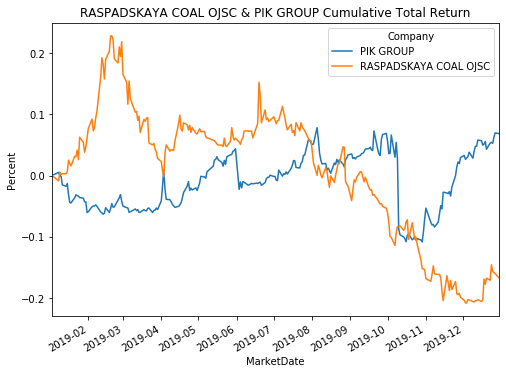

In [92]:
# comparing cumulative total return of the two companies
cum_total_return.plot(figsize=(8, 6))
plt.title('RASPADSKAYA COAL OJSC & PIK GROUP Cumulative Total Return')
plt.ylabel('Percent')
plt.show()

From the plot above we can conclude that cumulative returns of PIK Group didn't vary greatly in contrary to Raspadskaya.
If we have a stock portfolio where PIK - 80% and Raspadskaya - 20%, we can calculate portfolio's cumulative total return and volatility.

Text(0.5, 1.0, "Portfolio Cumulative Return vs Instruments' Cumulative Returns")

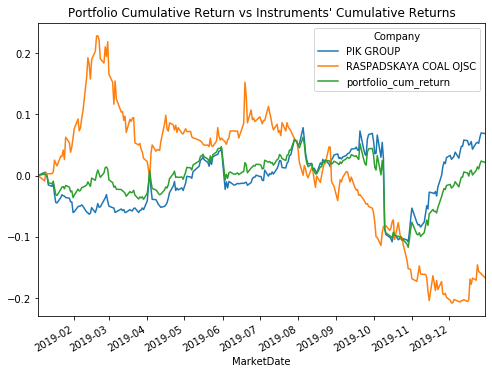

In [93]:
# plotting portfolio cumulative total return
cum_total_return['portfolio_cum_return'] = cum_total_return.apply(lambda row: row['PIK GROUP']*0.8 + row['RASPADSKAYA COAL OJSC']*0.2, axis=1)
cum_total_return.plot(figsize=(8, 6))
plt.title("Portfolio Cumulative Return vs Instruments' Cumulative Returns")

In [94]:
corr = cum_total_return['PIK GROUP'].corr(cum_total_return['RASPADSKAYA COAL OJSC'])
corr

-0.18912074808473542

In [95]:
# variety for pik
pik_var = cum_total_return['PIK GROUP'].var()
pik_var

0.002058377049186876

In [96]:
# pik's daily volatility
pik_std = cum_total_return['PIK GROUP'].std()
pik_std

0.045369340409431524

In [97]:
# pik's annualized volatility
pik_ann_std = pik_std*np.sqrt(252) 
pik_ann_std

0.7202159512223351

In [98]:
# variety for raspadskaya
rasp_var = cum_total_return['RASPADSKAYA COAL OJSC'].var()
rasp_var

0.011678136026292934

In [99]:
# daily volatility for raspadskaya
rasp_std = cum_total_return['RASPADSKAYA COAL OJSC'].std()
rasp_std

0.10806542474951428

In [100]:
# raspadskaya's annualized volatility
rasp_ann_std = rasp_std*np.sqrt(252)
rasp_ann_std

1.7154854352706757

In [101]:
# daily portfolio volatility (std)
daily_portfolio_vol = 0.8**2*pik_var + 0.2**2*rasp_var + 2*0.8*0.2*corr*pik_std*rasp_std
daily_portfolio_vol

0.0014877725152429358

Volatilities of companies are not additive when it comes to portfolio risk. One needs to account for correlations between the two stocks. As correlation is negative, a lot of risk is diversified away.

In [102]:
# annualized portfolio volatility
annual_portfolio_vol = daily_portfolio_vol*np.sqrt(252)
annual_portfolio_vol

0.023617656496619167

### Risk-adjusted Returns

In [103]:
risk_adj_return_pik = cum_total_return['PIK GROUP'].iloc[-1]/pik_ann_std
risk_adj_return_pik

0.09523265579147157

In [104]:
risk_adj_return_rasp = cum_total_return['RASPADSKAYA COAL OJSC'].iloc[-1]/rasp_ann_std
risk_adj_return_rasp

-0.09738192533694798

In [105]:
risk_adj_return_portfolio = cum_total_return['portfolio_cum_return'].iloc[-1]/annual_portfolio_vol
risk_adj_return_portfolio

0.9086001954033341

By combining two uncorrelated stocks in the portfolio we achieved a superior return for a unit of risk.